In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving PPD_LogInfo_3_1_Training_Set.csv to PPD_LogInfo_3_1_Training_Set.csv
Saving PPD_Training_Master_GBK_3_1_Training_Set.csv to PPD_Training_Master_GBK_3_1_Training_Set.csv
Saving PPD_Userupdate_Info_3_1_Training_Set.csv to PPD_Userupdate_Info_3_1_Training_Set.csv
User uploaded file "PPD_LogInfo_3_1_Training_Set.csv" with length 18337367 bytes
User uploaded file "PPD_Training_Master_GBK_3_1_Training_Set.csv" with length 20914088 bytes
User uploaded file "PPD_Userupdate_Info_3_1_Training_Set.csv" with length 15323941 bytes


In [7]:
import sys  
sys.getdefaultencoding()

'utf-8'

In [1]:
import pandas as pd
import datetime
import collections
import numpy as np
import numbers
import random
import pickle
import scipy
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from importlib import reload
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegressionCV

In [2]:
## all the functions

# 选择在某个时间段内的的字段
# 用来给日期分时间段
def TimeWindowSelection(df, daysCol, time_windows):
    '''
    :param df: the dataset containg variabel of days
    :param daysCol: the column of days
    :param time_windows: the list of time window
    :return:
    '''
    freq_tw = {}
    for tw in time_windows:
        freq = sum(df[daysCol].apply(lambda x: int(x<=tw)))
        freq_tw[tw] = freq
    return freq_tw
  

# 当分母为0时，返回0；否则返回正常值
def DeivdedByZero(nominator, denominator):
    if denominator == 0:
        return 0
    else:
        return nominator*1.0/denominator

      
#对某些统一的字段进行统一
def ChangeContent(x):
    y = x.upper()
    if y == '_MOBILEPHONE':
        y = '_PHONE'
    return y

def MissingCategorial(df,x):
    missing_vals = df[x].map(lambda x: int(x!=x))   # 不确实则为0
    return sum(missing_vals)*1.0/df.shape[0]

def MissingContinuous(df,x):
    missing_vals = df[x].map(lambda x: int(pd.isnull(x)))
    return sum(missing_vals) * 1.0 / df.shape[0]

def MakeupRandom(x, sampledList):
    # 非空时，都为true
    if x==x:
        return x
    else:
        randIndex = random.randint(0, len(sampledList)-1)
        return sampledList[randIndex]        



# check for column type and missing data
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])    # 按列拼，并给定列名
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [0]:
# 如果有报错，可以在后面加上encoding
log_info_train = pd.read_csv('PPD_LogInfo_3_1_Training_Set.csv', header = 0)
master_train = pd.read_csv('PPD_Training_Master_GBK_3_1_Training_Set.csv', header = 0)
update_train = pd.read_csv('PPD_Userupdate_Info_3_1_Training_Set.csv', header = 0)
log_info_train_ori = log_info_train.copy()
master_train_ori = master_train.copy()
update_train_ori = update_train.copy()

In [13]:
log_info_train.shape

(580551, 5)

In [12]:
missing_data(log_info_train)

,Idx,Listinginfo1,LogInfo1,LogInfo2,LogInfo3
Total,0,0,0,0,0
Percent,0,0,0,0,0
Types,int64,object,int64,int64,object


In [0]:
master_train.shape

(30000, 228)

In [14]:
missing_data(master_train)  #有部分列缺失十分严重，值得引起注意

,Idx,UserInfo_1,UserInfo_2,UserInfo_3,UserInfo_4,WeblogInfo_1,WeblogInfo_2,WeblogInfo_3,WeblogInfo_4,WeblogInfo_5,WeblogInfo_6,WeblogInfo_7,WeblogInfo_8,WeblogInfo_9,WeblogInfo_10,WeblogInfo_11,WeblogInfo_12,WeblogInfo_13,WeblogInfo_14,WeblogInfo_15,WeblogInfo_16,WeblogInfo_17,WeblogInfo_18,UserInfo_5,UserInfo_6,UserInfo_7,UserInfo_8,UserInfo_9,UserInfo_10,UserInfo_11,UserInfo_12,UserInfo_13,UserInfo_14,UserInfo_15,UserInfo_16,UserInfo_17,UserInfo_18,UserInfo_19,UserInfo_20,UserInfo_21,...,ThirdParty_Info_Period6_14,ThirdParty_Info_Period6_15,ThirdParty_Info_Period6_16,ThirdParty_Info_Period6_17,ThirdParty_Info_Period7_1,ThirdParty_Info_Period7_2,ThirdParty_Info_Period7_3,ThirdParty_Info_Period7_4,ThirdParty_Info_Period7_5,ThirdParty_Info_Period7_6,ThirdParty_Info_Period7_7,ThirdParty_Info_Period7_8,ThirdParty_Info_Period7_9,ThirdParty_Info_Period7_10,ThirdParty_Info_Period7_11,ThirdParty_Info_Period7_12,ThirdParty_Info_Period7_13,ThirdParty_Info_Period7_14,ThirdParty_Info_Period7_15,ThirdParty_Info_Period7_16,ThirdParty_Info_Period7_17,SocialNetwork_1,SocialNetwork_2,SocialNetwork_3,SocialNetwork_4,SocialNetwork_5,SocialNetwork_6,SocialNetwork_7,SocialNetwork_8,SocialNetwork_9,SocialNetwork_10,SocialNetwork_11,SocialNetwork_12,SocialNetwork_13,SocialNetwork_14,SocialNetwork_15,SocialNetwork_16,SocialNetwork_17,target,ListingInfo
Total,0,6,302,7,268,29030,1658,29030,1651,1651,1651,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18909,18909,18909,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0.02,1.00667,0.0233333,0.893333,96.7667,5.52667,96.7667,5.50333,5.50333,5.50333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63.03,63.03,63.03,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,int64,float64,object,float64,object,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,object,object,int64,float64,float64,float64,int64,int64,int64,int64,int64,object,object,int64,...,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object


In [15]:
update_train.shape

(372463, 4)

In [16]:
missing_data(update_train)

,Idx,ListingInfo1,UserupdateInfo1,UserupdateInfo2
Total,0,0,0,0
Percent,0,0,0,0
Types,int64,object,object,object


Updata表中的UserupdateInfo1，全部转为大写，防止出现不同名称的情况

Master表中的UserInfo_9字段中取值包括一些空格

master表中的UserInfo_8  UserInfo_19 UserInfo_20 字段 (不能全部都选，因为没有市的话就会报错)

In [0]:
update_train.loc[:,'UserupdateInfo1'] = update_train.loc[:,'UserupdateInfo1'].map(lambda x: x.upper())

In [0]:
master_train.loc[:,'UserInfo_9'] = master_train.loc[:,'UserInfo_9'].map(lambda x: x.strip())

In [0]:
master_train.loc[:,'UserInfo_8'] = master_train.loc[:,'UserInfo_8'].map(lambda x: x.split("市")[0])
master_train.loc[:,'UserInfo_19'] = master_train.loc[:,'UserInfo_19'].map(lambda x: x.split("市")[0])
master_train.loc[:,'UserInfo_20'] = master_train.loc[:,'UserInfo_20'].map(lambda x: x.split("市")[0])

In [20]:
[len(master_train.loc[:,'UserInfo_8'].unique().tolist()),
len(master_train.loc[:,'UserInfo_19'].unique().tolist()),
len(master_train.loc[:,'UserInfo_20'].unique().tolist()),
len(master_train_ori.loc[:,'UserInfo_8'].unique().tolist()),
len(master_train_ori.loc[:,'UserInfo_19'].unique().tolist()),
len(master_train_ori.loc[:,'UserInfo_20'].unique().tolist())]
# 发现含有市的列中，只有'UserInfo_8'是有重复的，从655变为了386

[386, 31, 297, 655, 31, 297]

compare whether the four city variables match：2,4,7,8,19,20

看为地点的列值是否完全相同。由此可知，所有列都不相同，都要保留

In [21]:
# apply 用在dataframe上，用于对row或者column进行计算
# applymap 用在dataframe中的每一个元素上
# map 用于series上，是元素级别的操作

location = ['UserInfo_2','UserInfo_4','UserInfo_7','UserInfo_8','UserInfo_19','UserInfo_20']
num = len(location)

same = {}     # 字典添加元素  user_info["height"] = 1.51  # 添加一个元素
for i in range(num):    # range不包括终止值
    for j in range(i+1,num):
        check = sum(master_train.loc[:,location[i]] != master_train.loc[:,location[j]]) == 0   #两列直接比较，其实是对应元素比较，输出多行 
        key = location[i]+location[j]
        value = check
        same[key] = value      # 字典写入新的行：给定key value即可
same

{'UserInfo_19UserInfo_20': False,
 'UserInfo_2UserInfo_19': False,
 'UserInfo_2UserInfo_20': False,
 'UserInfo_2UserInfo_4': False,
 'UserInfo_2UserInfo_7': False,
 'UserInfo_2UserInfo_8': False,
 'UserInfo_4UserInfo_19': False,
 'UserInfo_4UserInfo_20': False,
 'UserInfo_4UserInfo_7': False,
 'UserInfo_4UserInfo_8': False,
 'UserInfo_7UserInfo_19': False,
 'UserInfo_7UserInfo_20': False,
 'UserInfo_7UserInfo_8': False,
 'UserInfo_8UserInfo_19': False,
 'UserInfo_8UserInfo_20': False}

提取申请日期，计算日期差，查看日期差的分布

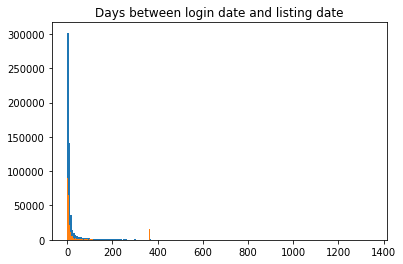

In [22]:
def TimeWindowSelection(df, daysCol, time_windows):
    '''
    :param df: the dataset containg variabel of days
    :param daysCol: the column of days
    :param time_windows: the list of time window
    :return:
    '''
    freq_tw = {}
    for tw in time_windows:
        freq = sum(df[daysCol].apply(lambda x: int(x<=tw)))
        freq_tw[tw] = freq
    return freq_tw


# 得到log和listing的差值，作为时间差
# 根据这个日期差进行后续的分箱

log_info_train['logInfo'] = log_info_train['LogInfo3'].map(lambda x: datetime.datetime.strptime(x,'%m/%d/%Y'))
log_info_train['Listinginfo'] = log_info_train['Listinginfo1'].map(lambda x: datetime.datetime.strptime(x,'%m/%d/%Y'))

log_info_train['ListingGap'] = log_info_train[['logInfo','Listinginfo']].apply(lambda x: (x[1]-x[0]).days, axis = 1)
plt.hist(log_info_train['ListingGap'],bins=200)

plt.title('Days between login date and listing date')
ListingGap2 = log_info_train['ListingGap'].map(lambda x: min(x,365))
plt.hist(ListingGap2,bins=200)

# 看一下他的分布
timeWindows = TimeWindowSelection(log_info_train, 'ListingGap', range(30,361,30))

In [23]:
timeWindows

{30: 499175,
 60: 524173,
 90: 535223,
 120: 542683,
 150: 548083,
 180: 552009,
 210: 555009,
 240: 557393,
 270: 559259,
 300: 560823,
 330: 562458,
 360: 563952}

# 对log_info_train进行预处理

In [0]:
# 时间本身没有意义，以某时间段内的登录次数作为新特征
'''
使用180天作为最大的时间窗口计算新特征
所有可以使用的时间窗口可以有7 days, 30 days, 60 days, 90 days, 120 days, 150 days and 180 days.
在每个时间窗口内，计算总的登录次数，不同的登录方式，以及每种登录方式的平均次数
'''

# 'LogInfo1','LogInfo2'中不同的编号理解为不同的登录方式
time_window = [7, 30, 60, 90, 120, 150, 180]
var_list = ['LogInfo1','LogInfo2']
log_info_train_GroupbyIdx = pd.DataFrame({'Idx':log_info_train['Idx'].drop_duplicates()})  #得到distinct的idx

# 不同时间差不同途径的loginfo
for tw in time_window:
    log_info_train['TruncatedLogInfo'] = log_info_train['Listinginfo'].map(lambda x: x + datetime.timedelta(-tw))
    temp = log_info_train.loc[log_info_train['logInfo'] >= log_info_train['TruncatedLogInfo']]
    # temp为在某个时间差内的记录

    for var in var_list:
        # count the frequences of LogInfo1 and LogInfo2
        # 即为统计每个id有的var的总个数
        count_stats = temp[var].groupby(temp['Idx']).count().to_dict()  # 单独.count()格式是乱的，要转为字典
        # Idx为key  count_stats.get(x,0)即为得到key对应的value
        # dict.get(key, num): 取到key对应的value，若不存在，则返回num
        log_info_train_GroupbyIdx[str(var)+'_'+str(tw)+'_count'] =\
                        log_info_train_GroupbyIdx['Idx'].map(lambda x: count_stats.get(x,0))
       

        # count the distinct value of LogInfo1 and LogInfo2    
        # 每个id，每个var只出现一次，即为统计一个id的distinct var
        Idx_UserupdateInfo1 = temp[['Idx', var]].drop_duplicates()
        uniq_stats = Idx_UserupdateInfo1[var].groupby(Idx_UserupdateInfo1['Idx']).count().to_dict()
        log_info_train_GroupbyIdx[str(var) + '_' + str(tw) + '_unique'] = \
                        log_info_train_GroupbyIdx['Idx'].map(lambda x: uniq_stats.get(x,0))

        
        # calculate the average count of each value in LogInfo1 and LogInfo2
        # 即为一个id，平均每个var出现啦多少次
        log_info_train_GroupbyIdx[str(var) + '_' + str(tw) + '_avg_count'] = \
            log_info_train_GroupbyIdx[[str(var)+'_'+str(tw)+'_count',str(var) + '_' + str(tw) + '_unique']].\
            apply(lambda x: DeivdedByZero(x[0],x[1]), axis=1)

# 对update_train进行分析

In [0]:
# 计算录入数据和update的时间差
update_train['ListingInfo'] = update_train['ListingInfo1'].map(lambda x: datetime.datetime.strptime(x,'%Y/%m/%d'))
update_train['UserupdateInfo'] = update_train['UserupdateInfo2'].map(lambda x: datetime.datetime.strptime(x,'%Y/%m/%d'))
update_train['ListingGap'] = update_train[['UserupdateInfo','ListingInfo']].apply(lambda x: (x[1]-x[0]).days,axis = 1)

In [26]:
# 统计各个时间间隔出现的次数
collections.Counter(update_train['ListingGap'])

Counter({0: 2861,
         1: 8229,
         2: 17698,
         3: 26174,
         4: 31571,
         5: 30527,
         6: 29226,
         7: 26804,
         8: 23964,
         9: 16761,
         10: 19564,
         11: 18298,
         12: 11577,
         13: 9848,
         14: 11927,
         15: 7732,
         16: 2446,
         17: 2361,
         18: 2199,
         19: 2267,
         20: 2037,
         21: 2030,
         22: 2313,
         23: 1981,
         24: 1902,
         25: 1503,
         26: 1769,
         27: 1375,
         28: 1042,
         29: 1129,
         30: 1030,
         31: 894,
         32: 759,
         33: 839,
         34: 968,
         35: 822,
         36: 859,
         37: 674,
         38: 784,
         39: 591,
         40: 524,
         41: 812,
         42: 595,
         43: 696,
         44: 504,
         45: 688,
         46: 615,
         47: 509,
         48: 496,
         49: 590,
         50: 561,
         51: 502,
         52: 413,
         53: 

In [28]:
hist_ListingGap

(array([343757,  12339,   5636,   3517,   2416,   1685,   1182,   1064,
           630,    237]),
 array([  0. ,  77.4, 154.8, 232.2, 309.6, 387. , 464.4, 541.8, 619.2,
        696.6, 774. ]))

In [0]:
# 用np.histogram，自动生成频率和具体数据（gap）对应着的array
# 取最后一行
hist_ListingGap = np.histogram(update_train['ListingGap'])
hist_ListingGap = pd.DataFrame({'Freq':hist_ListingGap[0],'gap':hist_ListingGap[1][1:]})
hist_ListingGap['CumFreq'] = hist_ListingGap['Freq'].cumsum()

# 利用map，对一列中的每个值进行变化
hist_ListingGap['CumPercent'] = hist_ListingGap['CumFreq'].map(lambda x: x*1.0/hist_ListingGap.iloc[-1]['CumFreq'])

In [0]:
# 把不同时间窗内的平均更新次数和有无重要特征更新作为新的特征

'''
 (1) 更新的频率
 (2) 每种更新对象的种类个数
 (3) 对重要信息如IDNUMBER, HASBUYCAR, MARRIAGESTATUSID, PHONE的更新
'''

update_train_GroupbyIdx = pd.DataFrame({'Idx':update_train['Idx'].drop_duplicates()})

time_window = [7, 30, 60, 90, 120, 150, 180]
for tw in time_window:
    update_train['TruncatedLogInfo'] = update_train['ListingInfo'].map(lambda x: x + datetime.timedelta(-tw))
    temp = update_train.loc[update_train['UserupdateInfo'] >= update_train['TruncatedLogInfo']]

    #frequency of updating   groupby后面可以只写列名，不用写df名
    freq_stats = temp['UserupdateInfo1'].groupby(temp['Idx']).count().to_dict()
    update_train_GroupbyIdx['UserupdateInfo_'+str(tw)+'_freq'] = update_train_GroupbyIdx['Idx'].map(lambda x: freq_stats.get(x,0))
    
    # number of updated types
    Idx_UserupdateInfo1 = temp[['Idx','UserupdateInfo1']].drop_duplicates()
    uniq_stats = Idx_UserupdateInfo1['UserupdateInfo1'].groupby(Idx_UserupdateInfo1['Idx']).count().to_dict()
    update_train_GroupbyIdx['UserupdateInfo_' + str(tw) + '_unique'] = update_train_GroupbyIdx['Idx'].map(lambda x: uniq_stats.get(x, 0))

    #average count of each type
    update_train_GroupbyIdx['UserupdateInfo_' + str(tw) + '_avg_count'] = \
        update_train_GroupbyIdx[['UserupdateInfo_'+str(tw)+'_freq', 'UserupdateInfo_' + str(tw) + '_unique']]. \
            apply(lambda x: DeivdedByZero(x[0],x[1]), axis=1)
  
 

    #whether the applicant changed items like IDNUMBER,HASBUYCAR, MARRIAGESTATUSID, PHONE
  
    # 先把每个变量转换为list。因为list.sum() ，是得到的是一个含有各个元素的大的list   eg: [_EDUCATIONID, _HASBUYCAR, _IDNUMBER, _LASTUPD...
    Idx_UserupdateInfo1['UserupdateInfo1'] = Idx_UserupdateInfo1['UserupdateInfo1'].map(lambda x: [x])
    Idx_UserupdateInfo1_V2 = Idx_UserupdateInfo1['UserupdateInfo1'].groupby(Idx_UserupdateInfo1['Idx']).sum()
    
    for item in ['_IDNUMBER','_HASBUYCAR','_MARRIAGESTATUSID','_PHONE']:
        item_dict = Idx_UserupdateInfo1_V2.map(lambda x: int(item in x)).to_dict()    # 用户更新了某个字段即为1，没有关系即为0
        update_train_GroupbyIdx['UserupdateInfo_' + str(tw) + str(item)] = update_train_GroupbyIdx['Idx'].map(lambda x: item_dict.get(x, 0))

In [0]:
# Combine the above features with raw features in PPD_Training_Master_GBK_3_1_Training_Set
allData = pd.concat([master_train.set_index('Idx'), update_train_GroupbyIdx.set_index('Idx'), log_info_train_GroupbyIdx.set_index('Idx')],axis= 1)
allData.to_csv('allData_0.csv', encoding = 'gbk')

数据转化到此结束，以下进行数据预处理

 # Step 2: 对类别型变量和数值型变量进行补缺

In [118]:
import os
import pandas as pd

path = os.path.abspath('./')
allData = pd.read_csv(path+'/allData_0.csv', encoding = 'gbk')

In [119]:
# list.remove("XX")  去掉XX  
allFeatures = list(allData.columns)
allFeatures.remove('target')
if 'Idx' in allFeatures:
    allFeatures.remove('Idx')
# master表中的一列，只有时间维度，没有用
allFeatures.remove('ListingInfo')

del 和remove这些涉及到。 函数会影响前面if中的复杂判断语句，使用时要小心。

要删除时，先把要删除的列名取出来，循环跳出后再删除

In [ ]:
'''
for col in allFeatures:
    if len(set(allData[col])) == 1:
        print(col)
'''

In [117]:
'''
for col in allFeatures:
    if len(set(allData[col])) == 1:
        print(col)
        del allData[col]
        allFeatures.remove(col)
'''

WeblogInfo_10
WeblogInfo_53
WeblogInfo_54
WeblogInfo_55


In [121]:
# 检查是否有常数型变量，并且检查是类别型还是数值型变量
# del allData[col] 删除一整列
# 判断有几个unique的值：可以用set()

numerical_var = []
delete_col = []

for col in allFeatures:
    if len(set(allData[col])) == 1:
        print(col)
        delete_col.append(col)

    else:
        uniq_valid_vals = [i for i in allData[col]]
        uniq_valid_vals = list(set(uniq_valid_vals))
        # numbers.Real，用于判断是否为float类型
        # 大于10且为数值类型才为数值，要不然视为factor
        if len(uniq_valid_vals) >= 10 and isinstance(uniq_valid_vals[0], numbers.Real):
            numerical_var.append(col)

categorical_var = [i for i in allFeatures if i not in numerical_var and i not in delete_col]

for col in delete_col:
    del allData[col]
    allFeatures.remove(col)

WeblogInfo_10
WeblogInfo_53
WeblogInfo_54
WeblogInfo_55


In [122]:
delete_col

['WeblogInfo_10', 'WeblogInfo_53', 'WeblogInfo_54', 'WeblogInfo_55']

Text(0.5,1,'Largest Percentage of Single Value in Each Variable')

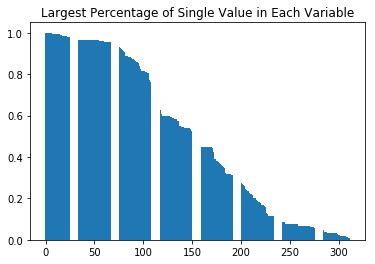

In [123]:
# 检查变量的最多值的占比情况,以及每个变量中占比最大的值
# 发现有些值占比超级大

records_count = allData.shape[0]
col_most_values = {}
col_largest_value = {}
for col in allFeatures:
    value_count = allData[col].groupby(allData[col]).count()
    col_most_values[col] = max(value_count)/records_count
    mask = value_count == max(value_count)
    large_value = value_count[mask].index[0]
    col_largest_value[col] = large_value

# pd.DataFrame.from_dict
# _df.sort_values(by = XX, ascending = False)
# index: 是按行写入（转为一列）     columns：是按列写入（转为多列）
col_most_values_df = pd.DataFrame.from_dict(col_most_values, orient = 'index')
col_most_values_df.columns = ['max percent']
col_most_values_df = col_most_values_df.sort_values(by = 'max percent', ascending = False)

pcnt = list(col_most_values_df[:500]['max percent'])
vars = list(col_most_values_df[:500].index)
plt.bar(range(len(pcnt)), height = pcnt)
plt.title('Largest Percentage of Single Value in Each Variable')

C:\Users\Alan_\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


<BarContainer object of 82 artists>

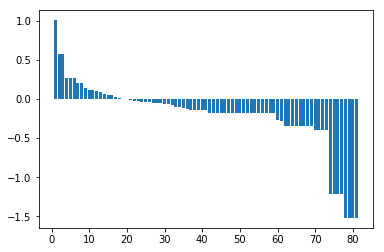

In [124]:
# 若少数样本逾期率没有显著的高，则可以直接删除这个字段
# （不管是字符型还是数值型）某个值占比超过90%的字段中，少数值的坏样本率是否会显著高于多数值。若少数样本坏样本率小，则可以删掉这个字段

# df.index：返回行名
# 列可以直接用列名取出来 bad_rate.iloc[0]['target']

large_percent_cols = list(col_most_values_df[col_most_values_df['max percent']>=0.9].index)

bad_rate_diff = {}
for col in large_percent_cols:
    large_value = col_largest_value[col]
    temp = allData[[col,'target']]
    temp[col] = temp.apply(lambda x: int(x[col]==large_value),axis=1)  # 最大值为1，要不然为0
    bad_rate = temp.groupby(col).mean()   # 要带上名称进行groupby,输出会自动排序
    if bad_rate.iloc[0]['target'] == 0:
        bad_rate_diff[col] = 0
        continue
    bad_rate_diff[col] = np.log(bad_rate.iloc[0]['target']/bad_rate.iloc[1]['target'])
    # 0的违约率显著大于1的违约率才会删除

bad_rate_diff_sorted = sorted(bad_rate_diff.items(), key=lambda x: x[1], reverse=True)   

# key用于比较，默认为可迭代对象   key=lambda x: x[1] 为对于字典的标准操作
bad_rate_diff_sorted_values = [x[1] for x in bad_rate_diff_sorted]
plt.bar(x = range(len(bad_rate_diff_sorted_values)), height = bad_rate_diff_sorted_values)

In [125]:
#由于所有的少数值的坏样本率并没有显著高于多数值，意味着这些变量可以直接剔除
for col in large_percent_cols:
    if col in numerical_var:
        numerical_var.remove(col)
    if col in categorical_var:
        categorical_var.remove(col)
    del allData[col]

In [126]:
def MakeupRandom(x, sampledList):
    # 非空时，都为true
    if x==x:
        return x
    else:
        randIndex = random.randint(0, len(sampledList)-1)  # 取随机数
        return sampledList[randIndex]                      # 返回一个

In [127]:
'''
对类别型变量，如果缺失超过90%, 就删除，否则当成特殊的状态
'''
missing_pcnt_threshould_1 = 0.9
for col in categorical_var:
    missingRate = MissingCategorial(allData,col)
    print('{0} has missing rate as {1}'.format(col,missingRate))
    if missingRate > missing_pcnt_threshould_1:
        categorical_var.remove(col)
        del allData[col]
    elif 0 < missingRate:
        uniq_valid_vals = [i for i in allData[col]]
        uniq_valid_vals = list(set(uniq_valid_vals))
        
        if isinstance(uniq_valid_vals[0], numbers.Real):   # 默认一列的都是相同的
            mask = allData[col] != allData[col]            # 只有空值才会在取不等号时为true
            missing_position = allData.loc[mask][col].index
            not_missing_sample = [-999999]*len(missing_position)   
            # 对于数值列，得到一个给定长度全为-999999的list，用来补全所有缺失值（因为我们把取值小于10的数值列也当做了类型变量）
            allData.loc[missing_position, col] = not_missing_sample
        else:
            # 对于非数值列，把NaN转化 一个特殊的类NAN
            # In this way we convert NaN to NAN, which is a string instead of np.nan
            allData[col] = allData[col].map(lambda x: str(x).upper())

allData_bk = allData.copy()


'''
对于数值型变量也是如此
'''
missing_pcnt_threshould_2 = 0.8
deleted_var = []
for col in numerical_var:
    missingRate = MissingContinuous(allData, col)
    print('{0} has missing rate as {1}'.format(col, missingRate))
    if missingRate > missing_pcnt_threshould_2:
        deleted_var.append(col)
        print('we delete variable {} because of its high missing rate'.format(col))
    elif missingRate > 0:
            # == 得到的是非空的值
            mask1 = allData[col] == allData[col]    # 非空的变量，取等号是1；空值的变量，取不等号为1
            not_missing = allData.loc[mask1][col]
            
            # 对于缺失值，从未缺失的值中随机选择进行补全
            mask2 = allData[col] != allData[col]
            missing_position = allData.loc[mask2][col].index
            
            # 因为有一些大于0.5的，所以抽样时需要需要有replce=true语句
            not_missing_sample = np.random.choice(list(not_missing), len(missing_position), replace=True)
            allData.loc[missing_position,col] = not_missing_sample

            missingRate2 = MissingContinuous(allData, col)
            print('missing rate after making up is:{}'.format(str(missingRate2)))
       

UserInfo_5 has missing rate as 0.0
UserInfo_6 has missing rate as 0.0
UserInfo_7 has missing rate as 0.0
UserInfo_8 has missing rate as 0.0
UserInfo_9 has missing rate as 0.0
UserInfo_10 has missing rate as 0.0
UserInfo_14 has missing rate as 0.0
UserInfo_15 has missing rate as 0.0
UserInfo_16 has missing rate as 0.0
UserInfo_17 has missing rate as 0.0
UserInfo_19 has missing rate as 0.0
UserInfo_20 has missing rate as 0.0
WeblogInfo_19 has missing rate as 0.08171886380189367
WeblogInfo_21 has missing rate as 0.08186453022578295
SocialNetwork_12 has missing rate as 7.283321194464675e-05
SocialNetwork_13 has missing rate as 7.283321194464675e-05
SocialNetwork_17 has missing rate as 7.283321194464675e-05
UserInfo_1 has missing rate as 0.0003641660597232338
missing rate after making up is:0.0
UserInfo_2 has missing rate as 0.009686817188638019
missing rate after making up is:0.0
UserInfo_3 has missing rate as 0.00043699927166788056
missing rate after making up is:0.0
UserInfo_4 has missin

missing rate after making up is:0.0
ThirdParty_Info_Period4_7 has missing rate as 7.283321194464675e-05
missing rate after making up is:0.0
ThirdParty_Info_Period4_8 has missing rate as 7.283321194464675e-05
missing rate after making up is:0.0
ThirdParty_Info_Period4_9 has missing rate as 7.283321194464675e-05
missing rate after making up is:0.0
ThirdParty_Info_Period4_10 has missing rate as 7.283321194464675e-05
missing rate after making up is:0.0
ThirdParty_Info_Period4_11 has missing rate as 7.283321194464675e-05
missing rate after making up is:0.0
ThirdParty_Info_Period4_12 has missing rate as 7.283321194464675e-05
missing rate after making up is:0.0
ThirdParty_Info_Period4_13 has missing rate as 7.283321194464675e-05
missing rate after making up is:0.0
ThirdParty_Info_Period4_14 has missing rate as 7.283321194464675e-05
missing rate after making up is:0.0
ThirdParty_Info_Period4_15 has missing rate as 7.283321194464675e-05
missing rate after making up is:0.0
ThirdParty_Info_Period

missing rate after making up is:0.0
UserupdateInfo_150_IDNUMBER has missing rate as 0.00021849963583394028
missing rate after making up is:0.0
UserupdateInfo_150_PHONE has missing rate as 0.00021849963583394028
missing rate after making up is:0.0
UserupdateInfo_180_freq has missing rate as 0.00021849963583394028
missing rate after making up is:0.0
UserupdateInfo_180_unique has missing rate as 0.00021849963583394028
missing rate after making up is:0.0
UserupdateInfo_180_avg_count has missing rate as 0.00021849963583394028
missing rate after making up is:0.0
UserupdateInfo_180_IDNUMBER has missing rate as 0.00021849963583394028
missing rate after making up is:0.0
UserupdateInfo_180_PHONE has missing rate as 0.00021849963583394028
missing rate after making up is:0.0
LogInfo1_7_count has missing rate as 0.07385287691187181
missing rate after making up is:0.0
LogInfo1_7_unique has missing rate as 0.07385287691187181
missing rate after making up is:0.0
LogInfo1_7_avg_count has missing rate a

In [128]:
deleted_var

['WeblogInfo_1', 'WeblogInfo_3']

In [129]:
if deleted_var != []:
    for col in deleted_var:
        numerical_var.remove(col)
        del allData[col]


allData.to_csv('allData_1.csv', header=True, encoding='gbk', columns = allData.columns, index=False)